<a href="https://colab.research.google.com/github/Anw-Gh/wake-word-detection/blob/main/wake_word_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!pip install -q pydub
!pip install -q librosa
!pip install -q audiomentations
!pip install -q elevenlabs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 50.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:
<|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|>'SYSTEM PROMPT'<|END_OF_TURN_TOKEN|>
<|START_OF_TURN_TOKEN|><|USER_TOKEN|>'USER PROMPT'<|END_OF_TURN_TOKEN|>
<|START_OF_TURN_TOKEN|><|CHATBOT_TOKEN|>'ASSISTANT MESSAGE'<|END_OF_TURN_TOKEN|>




## Install and Import libraries

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import IPython
import librosa

from shutil import copy
from google.colab import drive

from pydub import AudioSegment
from pydub.utils import mediainfo
from pydub.silence import split_on_silence

from scipy.io.wavfile import read
from scipy.signal import spectrogram



## Download DataSet

In [ ]:
drive.mount('/content/drive/')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/wake_word/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive/


In [ ]:
#remove exists datasets folders

!rm -rf /content/sample_data

!rm -rf /content/fluent-speech-corpus.zip
!rm -rf /content/alexa-dataset.zip

!rm -rf /content/fluent_speech_commands_dataset
!rm -rf /content/alexa

In [ ]:
# remove all my exists folders..

!rm -rf /content/XY_test
!rm -rf /content/XY_train
!rm -rf /content/models
!rm -rf /content/unstructured_data
!rm -rf my_data

In [ ]:
#download alexa dataset

!kaggle datasets download -q -d  aanhari/alexa-dataset
!unzip -q alexa-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/aanhari/alexa-dataset
License(s): DbCL-1.0


In [ ]:
#download negative dataset 1

#!kaggle datasets download -q -d tommyngx/fluent-speech-corpus
#!unzip -q fluent-speech-corpus.zip

Dataset URL: https://www.kaggle.com/datasets/tommyngx/fluent-speech-corpus
License(s): other


In [ ]:
#download negative dataset 2

!kaggle datasets download -d jbuchner/synthetic-speech-commands-dataset
!unzip -q synthetic-speech-commands-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/jbuchner/synthetic-speech-commands-dataset
License(s): CC-BY-SA-4.0
100% 1.76G/1.77G [01:33<00:00, 23.1MB/s]
100% 1.77G/1.77G [01:33<00:00, 20.2MB/s]


## Create Folders

In [ ]:
!mkdir -p unstructured_data/alexa unstructured_data/negatives unstructured_data/backgrounds

!mkdir -p my_data/alexa my_data/negatives my_data/backgrounds my_data/train_data my_data/test_data

!mkdir models XY_train XY_test
!mkdir voices
!mkdir alexa_sounds
!mkdir neg_sounds


#!rm -rf /content/fluent-speech-corpus.zip
!rm -rf /content/alexa-dataset.zip
!rm -rf /content/augmented_dataset_verynoisy
!rm -rf /content/filecounts.txt
!rm -rf /content/synthetic-speech-commands-dataset.zip

## Telegram BOT

In [ ]:
!pip install -q pyTelegramBotAPI
!pip install -q SpeechRecognition


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 68.0 MB/s eta 0:00:00


**read_write**

In [ ]:


def count_voices(tele_id):

    count=0
    id_list= []
    with open('data.txt', mode ='r+')as file:
        my_data = file.readlines()
        for line in my_data:
            entry = line.split(',')
            id_list.append(entry[0])

    for i in id_list:
        if i==tele_id:
            count+=1

    return count


def write_to(tele_id,user_name,time):
    with open('data.txt','a') as f:
        f.write(f'{tele_id},{user_name},{time}\n')





voice bot

In [ ]:
'''
5777312620:AAFpeOzy2ljKEB5RnF32jZOgnBKGBuviXIE

'''

msg1 = '''
مرحبا بك، نرجو منك إرسال رسالة صوتية وأنت تقول فيها "hey reemy" أو "reemy" حيث سيتم استخدام هذا الصوت لتدريب نموذج deep learning.

ملاحظات هامة:
- يجب ان لا يتعدى التسجيل الخاص بك 5 ثواني،
- يمكنك ارسال عدد صوتيات يصل إلى 5 صوتيات فقط.
- أي تسجيل لا يحوي الكلمة المطلوبة، سيتم التخلص منه بشكل تلقائي ولن يتم تخزينه.


بالنهاية: نحن نتوجه بالشكر الخالص لكم على تفديم المساعدة، أنتم شركاء لنا في نجاح هذا المشروع.😍
'''

import datetime
import telebot
from telebot import custom_filters
from telebot.handler_backends import State, StatesGroup
from telebot.storage import StateMemoryStorage
#from read_write import *

from pydub import AudioSegment

TOKEN = '6561401293:AAH6mIx5EMezaFLzsu5eNAk8NzSZDuxA9WI'

# Initialize the bot with bot token
state_storage = StateMemoryStorage()
bot = telebot.TeleBot(TOKEN,state_storage=state_storage)

#use this class to save states in every step (when need to)l.
class MyStates(StatesGroup):
    state1=State()
    state2=State()




# Define a handler for the /start command
@bot.message_handler(commands=['start'])
def start_message(message):


    user_name = message.from_user.username
    tele_id = message.from_user.id



    bot.send_message(message.chat.id,msg1)

   # with open('C:/Users/Anwar/Desktop/voice_bot/reemy.mp3', 'rb') as audio:
     #   bot.send_voice(message.chat.id, audio,caption = 'example.')


    bot.set_state(message.from_user.id, MyStates.state1, message.chat.id)

    print('done sending audio..')


@bot.message_handler(state=MyStates.state1,  content_types=['voice'])
def get_audio(message):

    user_name = message.from_user.username
    tele_id = message.from_user.id

    voice_info = bot.get_file(message.voice.file_id)

    print('i recived voice from ',user_name)


    NO_voices = count_voices(str(tele_id))


    if(NO_voices<100):
        voice_file = bot.download_file(voice_info.file_path)

        current_time = datetime.datetime.now()
        current_time = current_time.strftime("%Y%m%d%H%M%S")

        file_name = str(tele_id)+'_'+str(current_time)+'.wav'

        # Save the voice message as an wav file
        with open('tmp.ogg', 'wb') as f:
            f.write(voice_file)

        audio = AudioSegment.from_ogg('tmp.ogg')
        audio.export('voices/'+file_name, format="wav")


        write_to(str(tele_id),str(user_name),str(current_time))
        bot.reply_to(message, "Thank you for the voice message!")
        bot.reply_to(message, "Voice message saved.")
        print('voice message saved.')


    else:
        bot.reply_to(message, "Sorry, you have reached the limit for sending voice messages..")




@bot.message_handler(state=MyStates.state1, func=lambda message: True)
def handle_all_messages(message):
    bot.reply_to(message, "I'm sorry, I can only recive audio files. Please use the /start command.")





bot.add_custom_filter(custom_filters.StateFilter(bot))
bot.add_custom_filter(custom_filters.IsDigitFilter())

bot.infinity_polling(skip_pending=True)

is_wakeword

In [ ]:


import speech_recognition as sr
import os
from shutil import copy


# remy_list = [
# 'hey remy',
# 'hey reemy',
# 'hey remmy',
# 'hey rimi',
# 'hey rimy',
# 'hey reemmy',

# 'hi remy',
# 'hi reemy',
# 'hi remmy',
# 'hi rimi',
# 'hi rimy',
# 'hi reemmy',

# 'remy',
# 'reemy',
# 'remmy',
# 'rimi',
# 'rimy',
# 'reemmy'



# ]
remy_list = [
'alexa',
'allexa',
'alexaa',
'alex',
'lexa',
'exa',
'mexa',
'adexa',
'anexa',
'arexa',
'aleksa',
'leksa'
]


r = sr.Recognizer()

all_audio = os.listdir('voices')
count_reemy = 0
count_non = 0
for voice in all_audio:

    audio_file = '/content/voices/'+voice
    # print(audio_file)

    with sr.AudioFile(audio_file) as source:

        audio = r.record(source)


        try:
            text = r.recognize_google(audio)
            print("Converted Text:")
            print(text)

            if text.lower() in remy_list:
                count_reemy+=1
                copy(audio_file,'/content/my_alexa/'+str(count_reemy)+'.wav')

            else:
                count_non+=1
                copy(audio_file,'/content/my_neg/'+str(count_non)+'.wav')


        except sr.UnknownValueError:
            print("Speech recognition could not understand audio")
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))

Speech recognition could not understand audio
Converted Text:
Alexa
Converted Text:
Alexa
Speech recognition could not understand audio
Converted Text:
Alexa
Converted Text:
Alexa
Speech recognition could not understand audio
Speech recognition could not understand audio
Converted Text:
Alexa
Converted Text:
hello
Speech recognition could not understand audio
Converted Text:
Alexa
Speech recognition could not understand audio
Speech recognition could not understand audio
Converted Text:
Alexa
Converted Text:
Alexa
Converted Text:
Alexa
Speech recognition could not understand audio
Converted Text:
Alexa
Speech recognition could not understand audio
Speech recognition could not understand audio
Converted Text:
Alexa
Converted Text:
Alexa
Converted Text:
thank you
Converted Text:
Alexa
Speech recognition could not understand audio
Speech recognition could not understand audio
Converted Text:
Alexa
Converted Text:
Alexa
Converted Text:
Alexa
Speech recognition could not understand audio
Co

## count and move Dataset to my folders

In [ ]:
'''
move alexa online to alexa foder
'''

alexa_path = os.listdir('/content/alexa/alexa/')
count=0
for folder in alexa_path:

  folder = '/content/alexa/alexa/'+folder

  for file in os.listdir(folder):
    copy(folder+'/'+file, "/content/unstructured_data/alexa/alexa_"+str(count)+"."+file.split('.')[1])
    count+=1

print('alexa folder got: ',count,' files')

alexa folder got:  369  files


In [ ]:
#move my_alexa
count=0
for file in os.listdir('/content/my_alexa/'):
  copy('/content/my_alexa/'+'/'+file, "/content/unstructured_data/alexa/alexa_"+str(count)+"."+file.split('.')[1])
  count+=1

print('alexa folder got: ',count,' files')

FileNotFoundError: [Errno 2] No such file or directory: '/content/my_alexa/'

In [ ]:
'''
move negative online to negative foder
'''


negative_path = os.listdir('/content/augmented_dataset/augmented_dataset')

count=0
for i in range(1000): #1000
  rand_folder = random.randint(0,len(negative_path)-1)
  folder = negative_path[rand_folder]

  files = os.listdir('/content/augmented_dataset/augmented_dataset/'+folder)

  for j in range(3): #3
    rand_audio = random.randint(0,len(files)-1)

    audio_file = files[rand_audio]
    audio_file_path = '/content/augmented_dataset/augmented_dataset/'+folder +'/'+audio_file

    copy(audio_file_path, "/content/unstructured_data/negatives/neg_"+str(count)+"."+file.split('.')[1])
    count+=1



print('negatives folder got: ',count,' files')

negatives folder got:  3000  files


In [ ]:
#move my_neg
count = 0
for file in os.listdir('/content/my_neg/'):
  copy('/content/my_neg/'+'/'+file, "/content/unstructured_data/negatives/neg_"+str(count)+"."+file.split('.')[1])
  count+=1

print('negatives folder got: ',count,' files')

FileNotFoundError: [Errno 2] No such file or directory: '/content/my_neg/'

In [ ]:
'''
move negative online to negative foder
'''


negative_path = os.listdir('/content/fluent_speech_commands_dataset/wavs/speakers/')

count=0
for i in range(1000): #1000
  rand_folder = random.randint(0,len(negative_path)-1)
  folder = negative_path[rand_folder]

  files = os.listdir('/content/fluent_speech_commands_dataset/wavs/speakers/'+folder)

  for j in range(3): #3
    rand_audio = random.randint(0,len(files)-1)

    audio_file = files[rand_audio]
    audio_file_path = '/content/fluent_speech_commands_dataset/wavs/speakers/'+folder +'/'+audio_file

    copy(audio_file_path, "/content/unstructured_data/negatives/neg_"+str(count)+"."+file.split('.')[1])
    count+=1


print('negatives folder got: ',count,' files')

FileNotFoundError: [Errno 2] No such file or directory: '/content/fluent_speech_commands_dataset/wavs/speakers/'

In [ ]:
'''
move background drive to background foder
'''

background_path = os.listdir('/content/drive/MyDrive/wake_word/background/')

count=0

for file in background_path:
  copy('/content/drive/MyDrive/wake_word/background/'+file, "/content/unstructured_data/backgrounds/back_"+str(count)+"."+file.split('.')[1])
  count+=1

print('backgrounds folder got: ',count,' files')

backgrounds folder got:  8  files


# unnecessary step :)

In [ ]:
!pip install -q torch torchaudio -f https://download.pytorch.org/whl/cpu/torch_stable.html
!pip install -q deepfilternet

In [ ]:
from df.enhance import enhance, init_df, load_audio, save_audio
from df.utils import download_file


def clean_audio(audio_path):
    model, df_state, _ = init_df()
    audio, _ = load_audio(audio_path, sr=df_state.sr())
    enhanced = enhance(model, df_state, audio)

    save_audio(audio_path, enhanced, df_state.sr())



# *Data augiomentation*

In [ ]:
import librosa
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, PitchShift, HighPassFilter

def augment_audio(audio,value):

  # Raw audio augmentation
  augment_raw_audio = Compose(
      [
          #AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.0015, p=1),
          PitchShift(min_semitones=-value, max_semitones=value, p=1),
          #HighPassFilter(min_cutoff_freq=2000, max_cutoff_freq=4000, p=1)
      ]
  )
for i in range(3,9)
  signal, sr = librosa.load(audio_path)
  augmented_signal = augment_raw_audio(signal, sr)
  sf.write("/content/unstructured_data/alexa", augmented_signal, sr)

#Preparing Data

In [ ]:

def split_backgrounds(audio,dst,audio_file_name):

    num_clips = int(audio.duration_seconds / 10)

    clips = []
    count_b=0
    for i in range(num_clips):
      start_time = i * 10000
      end_time = start_time + 10000
      clips.append(audio[start_time:end_time])
      count_b+= 1

    i=1
    for audio_i in clips:

        audio_i.export(dst+'backgrounds/'+str(i)+audio_file_name.split('.')[0]+'.wav',format = 'wav',bitrate="128K")
        i+=1

    return count_b


def cut_silnce(audio,thresh):
    chunks = split_on_silence(
      audio,
      min_silence_len = 500,
      silence_thresh = thresh,)

    return chunks


def prc_alexa(audio):

  chunks=[]
  tmp_list=[]
  tmp_var = 0
  s = 0

  chunks = cut_silnce(audio,-50)
  for i in chunks:
    tmp_var = len(i)
    tmp_list.append(tmp_var)

  if max(tmp_list)>1000:  #that's means the voice contain some low noise
    chunks = cut_silnce(audio,-40)


  if len(chunks)==1:
    alexa = chunks[0]
    if len(alexa)>400 and len(alexa)<1200:
      return alexa
    else:
      return -1

  elif len(chunks)>1:
    s = max(tmp_list)
    indx = tmp_list.index(s)
    alexa = chunks[indx]

    if len(alexa)>400 and len(alexa)<1200:
        return alexa
    else:
        return -1

  else:
    print('no silence')
    return -1

#sound = process_alexa('/content/unstructured_data/alexa/alexa_261.wav')
#sound.export('/content/aa.wav',format='wav')
#IPython.display.Audio('/content/aa.wav')

In [ ]:
c=0
dur_list=[]
sound_list=[]
file_list=[]
for i in os.listdir('/content/unstructured_data/alexa/'):
  file  = '/content/unstructured_data/alexa/' + i

  audio = AudioSegment.from_wav(file)
  alexa = prc_alexa(audio)

  if alexa == -1:
    pass
  else:
    file_list.append(file)
    c+=1
    sound_list.append(alexa)
    dur_list.append(len(alexa))
    #print('file ',c,': ',file,'\t\tlen_before: ',len(audio),'\t\tlen_after: ',len(alexa))



CouldntDecodeError: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-lv2 --enable-omx --enable-openal --enable-opencl --enable-opengl --enable-sdl2 --enable-pocketsphinx --enable-librsvg --enable-libmfx --enable-libdc1394 --enable-libdrm --enable-libiec61883 --enable-chromaprint --enable-frei0r --enable-libx264 --enable-shared
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libswscale      5.  9.100 /  5.  9.100
  libswresample   3.  9.100 /  3.  9.100
  libpostproc    55.  9.100 / 55.  9.100
[wav @ 0x567b1ebad780] invalid start code [255][251][144][196] in RIFF header
/content/unstructured_data/remi/remi_7.wav: Invalid data found when processing input


In [ ]:
'''
1. make all sounds .WAV
2. make all sound same length for background. length = 10 sec (10000.0)
3. make all alexa sound length around 2 sec.
4. make all negative sound length around 2 sec.
6. make all voices in same sample rate.
5. move all prepared files to my_data folder.
'''



def preparing_data(scr,dst, proc_backg = False ,proc_neg = False ,proc_alexa = False):
    sample_rate = 44100
    count_b = 0
    count_a = 0
    count_n = 0

    folders = os.listdir(scr) #return backgrounds activates negatvies...

    for folder in folders: #folders[0] = backdrounds | folders[1] = negative ....
        files = ''
        files = os.listdir(scr+f'{folder}')


        if folder =='backgrounds' and proc_backg:
            for audio_file in files:

                audio_file_name = audio_file
                audio_file = scr+folder+'/'+audio_file

                if audio_file_name.endswith('.wav'):
                    audio = AudioSegment.from_wav(audio_file)
                    audio = audio.set_frame_rate(sample_rate)
                    x =split_backgrounds(audio, dst, audio_file_name)
                    count_b+=x
                else:
                    audio = AudioSegment.from_file(audio_file,format=audio_file_name.split('.')[1])
                    audio = audio.set_frame_rate(sample_rate)
                    x = split_backgrounds(audio, dst, audio_file_name)
                    count_b+=x
            print('done process ',count_b,' backgrounds sounds')


        if folder == 'negatives' and proc_neg:
            for audio_file in files:

                audio_file_name = audio_file
                audio_file = scr+folder+'/'+audio_file

                if audio_file_name.endswith('.wav'):
                    audio = AudioSegment.from_wav(audio_file)
                    #audio = audio[1000:2500]
                    audio = audio.set_frame_rate(sample_rate)
                    audio.export(dst+'negatives/'+audio_file_name,format = 'wav')
                    count_n+=1

                else:
                    audio = AudioSegment.from_file(audio_file,format=audio_file_name.split('.')[1])
                    #audio = audio[1000:2500]
                    audio = audio.set_frame_rate(sample_rate)  #set frame 8 KHz
                    audio.export(dst+'negatives/'+audio_file_name.split('.')[0]+'.wav',format = 'wav')
                    count_n+=1
            print('done process ',count_n,' negatives sounds')



        if folder == 'alexa' and proc_alexa:

            for audio_file in files:

                audio_file_name = audio_file
                audio_file = scr+folder+'/'+audio_file


                if audio_file_name.endswith('.wav'):
                    audio = AudioSegment.from_wav(audio_file)
                    audio = audio.set_frame_rate(sample_rate)
                    #audio = prc_alexa(audio)

                    if audio == -1:
                      pass

                    else:
                      audio.export(dst+'alexa/'+audio_file_name,format = 'wav')
                      count_a+=1


                else:
                    audio = AudioSegment.from_file(audio_file,format=audio_file_name.split('.')[1])
                    audio = audio.set_frame_rate(sample_rate)
                    audio = prc_alexa(audio)

                    if audio == -1:
                      pass
                    else:
                      audio.export(dst+'alexa/'+audio_file_name.split('.')[0]+'.wav',format = 'wav')
                      count_a+=1

            print('done process ',count_a,' alexa sounds')



scr = '/content/unstructured_data/'
dst = '/content/my_data/'
preparing_data(scr,dst,proc_backg = True ,proc_neg = True ,proc_alexa = True)

done process  3000  negatives sounds
done process  369  alexa sounds
done process  62  backgrounds sounds


In [ ]:
def get_info(audio_file):

  audio_info = mediainfo(audio_file)
  duration = audio_info.get("duration")
  bit_rate = audio_info.get("bit_rate")
  sample_rate = audio_info.get("sample_rate")
  channels = audio_info.get("channels")

  print("Duration:", duration)
  print("Bit Rate:", bit_rate)
  print("Channels:", channels)
  print("Sample Rate:", sample_rate)

print('====================Remi====================')

audio_file = "/content/my_data/alexa/alexa_12.wav"
get_info(audio_file)


audio_file = "/content/my_data/alexa/alexa_15.wav"
get_info(audio_file)


print('====================background====================')


audio_file = "/content/my_data/backgrounds/10back_7.wav"
get_info(audio_file)

audio_file = "/content/my_data/backgrounds/19back_2.wav"
get_info(audio_file)

print('====================negative====================')


audio_file = "/content/my_data/negatives/neg_2.wav"
get_info(audio_file)

audio_file = "/content/my_data/negatives/neg_3.wav"
get_info(audio_file)

====================Remi====================
Duration: 1.439955
Bit Rate: 705844
Channels: 1
Sample Rate: 44100
Duration: 1.959955
Bit Rate: 705779
Channels: 1
Sample Rate: 44100
====================background====================
Duration: 10.000000
Bit Rate: 1411235
Channels: 2
Sample Rate: 44100
Duration: 10.000000
Bit Rate: 1411235
Channels: 2
Sample Rate: 44100
====================negative====================
Duration: 0.999955
Bit Rate: 705951
Channels: 1
Sample Rate: 44100
Duration: 0.999955
Bit Rate: 705951
Channels: 1
Sample Rate: 44100


# test the audio

In [ ]:
IPython.display.Audio('/content/my_data/negatives/neg_4.wav')

In [ ]:
IPython.display.Audio("/content/unstructured_data/alexa/alexa_18.wav")

# Preprocess Data

In [ ]:
!rm /content/my_data/train_data/*
!rm /content/my_data/test_data/*
!rm /content/XY_train/*
!rm /content/XY_test/*

rm: cannot remove '/content/XY_train/*': No such file or directory
rm: cannot remove '/content/XY_test/*': No such file or directory


In [ ]:
a=[]
i=64
while True:

  i*=64

  a.append(i)

In [ ]:
Tx=5511
Ty=1375
n_freq = 101


'''
load data into lists as pydub array..
'''


def load_data(path): #path is my_data
    alexa_list = []
    backgrounds_list = []
    negatives_list = []

    for audio_file in os.listdir(path+'alexa'):

        alexa = AudioSegment.from_wav(path + "alexa/" + audio_file)
        alexa_list.append(alexa)

    for audio_file in os.listdir(path+'backgrounds'):

        background = AudioSegment.from_wav(path + "backgrounds/" + audio_file)
        backgrounds_list.append(background)

    for audio_file in os.listdir(path+'negatives'):

        negative = AudioSegment.from_wav(path + "negatives/" + audio_file)
        negatives_list.append(negative)

    return alexa_list,backgrounds_list,negatives_list



# alexa_list ,backgrounds_list,negatives_list = load_data('my_data/')

'''
pick random time from background sound
'''

def get_random_time_segment(segment_ms):

    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # NOT run after the 10sec background
    segment_end = segment_start + segment_ms - 1

    return (segment_start, segment_end)



'''
check if there is an overlapping
'''
#takes(the random part, the pre_segment)
def is_overlapping(segment_time, previous_segments):

    overlap = False

    for previous_start, previous_end in previous_segments:
        if segment_time[0] <= previous_end and segment_time[1] >= previous_start:
            overlap = True


    return overlap




# overlap1 = is_over_lapping((950, 1430), [(2000, 2550), (260, 949)])



'''
insert audio into background
'''

# insert_audio_clip(original background, the audio we want to insert(alexa or negative), the previeos segment we inserted)
def insert_audio_clip(background, audio_clip, previous_segments):

    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(segment_ms)

    retry = 7
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1

    if not is_overlapping(segment_time, previous_segments):
        previous_segments.append(segment_time)
        new_background = background.overlay(audio_clip, position = segment_time[0])

    else:
        #print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)

    return new_background, segment_time




def insert_ones(y, segment_end_ms):

    segment_end_y = int(segment_end_ms * Ty / 10000.0)

    for i in range(segment_end_y+1, segment_end_y+50):
        if i < y.shape[1]:  #Y.shape: 1,246
            y[0, i] = 1
    return y






## Feature Extraction

In [ ]:
'''
some helper function...
'''
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment


# normalizing audio volume, same  amplitude
# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)



# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data
'''
def plot_spectrogram(wav_file):

    rate, data = read(wav_file)

    nfft = 200
    fs = 8000
    noverlap = 120
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx
'''

graph_spectrogram

<function __main__.graph_spectrogram(wav_file)>

## Load Data

In [ ]:
#load Data
alexa_list ,backgrounds_list,negatives_list = load_data('my_data/')




def create_data_example(background, alexa_list, negatives_list, Ty,name,to_test):


    background-=30 #quiter...


    y = np.zeros((1,Ty))

    previous_segment = []



    number_of_alexa = np.random.randint(1, 4)


    #make rand list have size , and choise from [0 to len(alexa_list)]
    rand_indx_alexa = np.random.randint(len(alexa_list),size = number_of_alexa) #random(len_list = 20, number of choise  = 3) ---> choise 3 from list


    # i have random index list...

    # alexa_list = ['a','c','b','xz']
    # rand_indx_alexa = [1,3,2]
    # get: [c,xz,b]
    random_alexas=  [alexa_list[i] for i in rand_indx_alexa]


    #time to insert alexa in background

    for random_alexa in random_alexas:

        background,segment_time = insert_audio_clip(background, random_alexa, previous_segment) #it return new backgroun and the duration of where we add alexa

        start_seg,end_seg = segment_time

        y = insert_ones(y, end_seg)



    number_of_neg = np.random.randint(1,3)
    rand_indx_neg = np.random.randint(len(negatives_list),size = number_of_neg)


    random_negatives = [negatives_list[i] for i in rand_indx_neg]


    for random_negative in random_negatives:
        background, _ = insert_audio_clip(background, random_negative, previous_segment)


    background = match_target_amplitude(background, -20.0)



    if to_test:


      file_handle = background.export(f"my_data/test_data/data_" +name+ ".wav", format="wav")

      # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
      x = graph_spectrogram(f"my_data/test_data/data_" +name+ ".wav")

      return x,y


    else:

      file_handle = background.export(f"my_data/train_data/data_" +name+ ".wav", format="wav")

      # Get and plot spectrogram of the new audio (background with superposition of positive and negatives)
      x = graph_spectrogram(f"my_data/train_data/data_" +name+ ".wav")

      return x,y








nsamples = 1500
X_train = []
Y_train= []
X_test = []
Y_test = []
train_count = 0
test_count = 0


#Create Dataset

In [ ]:
to_test = False
for i in range(0, nsamples):

    if i % 500 == 0:
      print(i)
    rand = random.randint(0,61)

    if i%5 == 0:


      x, y = create_data_example(backgrounds_list[rand], alexa_list, negatives_list, Ty, name=str(i),to_test = True)
      X_test.append(x.swapaxes(0,1))
      Y_test.append(y.swapaxes(0,1))
      test_count+=1

    else:

      x, y = create_data_example(backgrounds_list[rand], alexa_list, negatives_list, Ty, name=str(i),to_test = False)
      X_train.append(x.swapaxes(0,1))
      Y_train.append(y.swapaxes(0,1))
      train_count+=1


print("Number of training samples:", train_count)
print("Number of testing samples:", test_count)
# so now X,Y have all data, train and dev....

X_train = np.array(X_train)
Y_train = np.array(Y_train)

np.save('XY_train/X_train.npy', X_train)
np.save('XY_train/Y_train.npy', Y_train)


X_test = np.array(X_test)
Y_test = np.array(Y_test)
np.save('XY_test/X_test.npy', X_test)
np.save('XY_test/Y_test.npy', Y_test)


print('done saving')

print('X_train.shape: ',X_train.shape)
print('Y_train.shape: ',Y_train.shape)

0


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


500
1000
Number of training samples: 1200
Number of testing samples: 300
done saving
X_train.shape:  (1200, 5511, 101)
Y_train.shape:  (1200, 1375, 1)
Error in callback <function flush_figures at 0x7e213df7c670> (for post_execute):


KeyboardInterrupt: 

# Build Model

In [ ]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [ ]:
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, Conv1D
from tensorflow.keras.layers import GRU,LSTM, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split

In [ ]:
X_train = np.load("XY_train/X_train.npy")
Y_train = np.load("XY_train/Y_train.npy")

X_test = np.load("XY_test/X_test.npy")
Y_test = np.load("XY_test/Y_test.npy")


print('X.train.shape: ',X_train.shape)
print('Y.train.shape: ',Y_train.shape)
print('X.test.shape: ',X_test.shape)
print('Y.test.shape: ',Y_test.shape)

X.train.shape:  (1200, 5511, 101)
Y.train.shape:  (1200, 1375, 1)
X.test.shape:  (300, 5511, 101)
Y.test.shape:  (300, 1375, 1)


In [ ]:
def model(input_shape):


    X_input = Input(shape = input_shape)

    X = Conv1D(filters=196, kernel_size=15, strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.8)(X)

    X = GRU(128, return_sequences=True)(X)
    X = Dropout(rate=0.8)(X)
    X = BatchNormalization()(X)

    X = GRU(128, return_sequences=True)(X)
    X = Dropout(rate=0.8)(X)
    X = BatchNormalization()(X)
    X = Dropout(rate=0.8)(X)

    X = TimeDistributed(Dense(1, activation='sigmoid'))(X)


    model = Model(inputs = X_input, outputs = X)

    return model

In [ ]:
model = model(input_shape = (Tx, n_freq))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5511, 101)]       0         
                                                                 
 conv1d (Conv1D)             (None, 1375, 196)         297136    
                                                                 
 batch_normalization (Batch  (None, 1375, 196)         784       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1375, 196)         0         
                                                                 
 dropout (Dropout)           (None, 1375, 196)         0         
                                                                 
 gru (GRU)                   (None, 1375, 128)         125184    
                                                             

#train and test dataset

In [ ]:
X_train1, X_val, Y_train1, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


# now we have train and val dataset, and Test data with audio....

In [ ]:
opt = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

history = model.fit(X_train, Y_train, epochs=7, batch_size = 5, validation_data=(X_test,Y_test))

model.save('models/my_model.h5')

Epoch 1/7
240/240 [==============================] - 34s 107ms/step - loss: 1.0150 - accuracy: 0.5700 - val_loss: 0.6063 - val_accuracy: 0.9224
Epoch 2/7
240/240 [==============================] - 23s 96ms/step - loss: 0.8732 - accuracy: 0.7114 - val_loss: 0.5805 - val_accuracy: 0.9279
Epoch 3/7
240/240 [==============================] - 23s 96ms/step - loss: 0.8410 - accuracy: 0.7658 - val_loss: 0.5666 - val_accuracy: 0.9300
Epoch 4/7
240/240 [==============================] - 23s 96ms/step - loss: 0.8223 - accuracy: 0.7953 - val_loss: 0.5552 - val_accuracy: 0.9312
Epoch 5/7
240/240 [==============================] - 23s 96ms/step - loss: 0.8080 - accuracy: 0.8108 - val_loss: 0.5471 - val_accuracy: 0.9319
Epoch 6/7
240/240 [==============================] - 23s 97ms/step - loss: 0.7959 - accuracy: 0.8203 - val_loss: 0.5409 - val_accuracy: 0.9323
Epoch 7/7
240/240 [==============================] - 23s 96ms/step - loss: 0.7877 - accuracy: 0.8284 - val_loss: 0.5361 - val_accuracy: 0.932

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
  model = load_model('/content/models/my_model.h5')

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

10/10 [==============================] - 3s 92ms/step - loss: 0.5361 - accuracy: 0.9325
Test Loss: 0.5360948443412781
Test Accuracy: 0.9325066804885864


In [ ]:
loss, accuracy = model.evaluate(X_train, Y_train)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

38/38 [==============================] - 3s 68ms/step - loss: 0.5375 - accuracy: 0.9335
Test Loss: 0.5375072956085205
Test Accuracy: 0.9334502816200256


<function matplotlib.pyplot.show(close=None, block=None)>

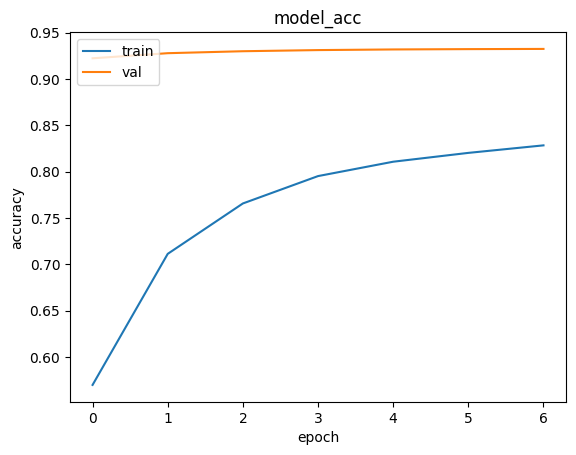

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

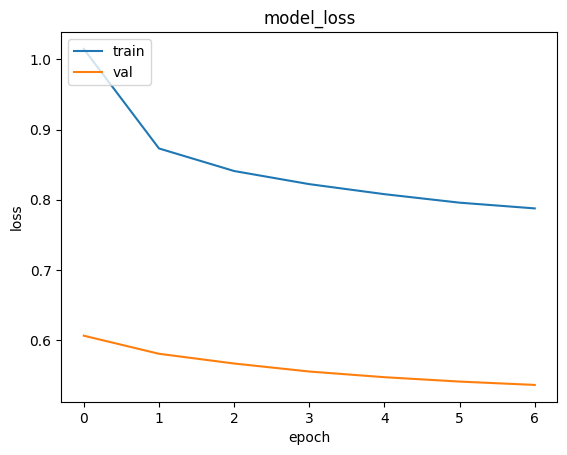

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

# make predictions

1/1 [==============================] - 1s 655ms/step


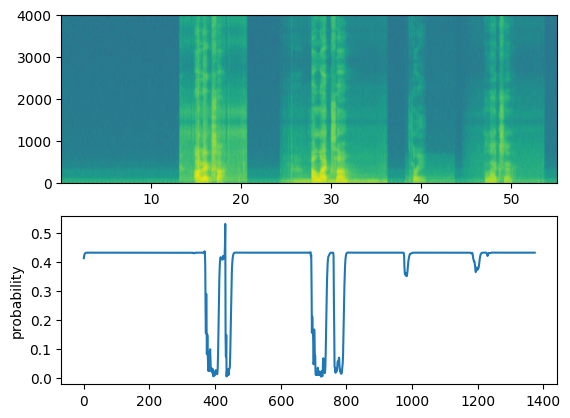

In [ ]:
model = load_model('/content/models/my_model.h5')

def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    #x = graph_spectrogram(filename)

    x = graph_spectrogram(filename)

    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)   #x.shape = 5511,101

    x = np.expand_dims(x, axis=0)  #x.shape = 1,998,101
    predictions = model.predict(x)

    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions




bing_file = "/content/drive/MyDrive/wake_word/bing.wav"
def bing_on_activate(filename, predictions, threshold):

    audio_clip = AudioSegment.from_wav(filename)

    bing = AudioSegment.from_wav(bing_file)

    Ty = predictions.shape[1] #994


    consecutive_timesteps = 0


    for i in range(Ty):

        consecutive_timesteps += 1

        if predictions[0,i,0] < threshold:
            consecutive_timesteps = 0

        if consecutive_timesteps > 10:
            audio_clip = audio_clip.overlay(bing, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            consecutive_timesteps = 0


    audio_clip.export("outpu.wav", format='wav')


def preprocess_audio(filename):

    padding = AudioSegment.silent(duration=10000) #add 10s
    segment = AudioSegment.from_wav(filename)[:10000] #cut first 10s
    segment = padding.overlay(segment)
    segment = segment.set_frame_rate(44100)
    segment.export(filename, format='wav')






filename = '/content/my_data/test_data/data_955.wav'
preprocess_audio(filename )
prediction = detect_triggerword(filename)
bing_on_activate(filename, prediction, 0.5)

IPython.display.Audio("outpu.wav")